### A quick note on Python <> Julia integration
The below script relies on Matplotlib and PyTorch being available in the Conda environment attached to Julia. If you don't tend to use Julia very much, you may want to attach one of your favourite Python environments to Julia to avoid reinstalling a bunch of stuff. To do this, run the following commands with the appropriate Python executable referenced. (If PyCall is not yet installed, you could use `pkg"add PyCall"` instead of `build`.

```julia
ENV["PYTHON"]=expanduser("~/anaconda3/envs/mkl/bin/python")  # change path here
using Pkg
pkg"build PyCall"
```
Thanks to [Przemyslaw Szufel](https://stackoverflow.com/a/63182917) for this notebook friendly route.

In [1]:
using MeshCat

In [2]:
using LinearAlgebra, Statistics, StatsBase, Random
using PyPlot
using BSON, NPZ, CSV, Tables

using MeshCat
using Quaternions, GeometryBasics, CoordinateTransformations

In [3]:
# Project-specific Julia code
include("viz/mocap_viz.jl")
include("viz/expmtdata.jl")
include("viz/geom3d.jl")
include("viz/prettytbl.jl")
include("viz/util.jl")

Main.mocaputil

## Load in data

Recall that the 30fps processed data can be downloaded from [https://bit.ly/38x2sra](https://bit.ly/38x2sra). Once downloaded, please store the `.npz` files in the `data/` directory in the base project (parent) folder.

In [4]:
# database = "../../mocap-mtds-macbook/data/edin-style-transfer/"
# files_edin = [joinpath(database, f) for f in readdir(database)];
# style_name_edin = [x[1] for x in match.(r"[a-z\-]+/[a-z\-]+/([a-z]+)_.*", files_edin)];
# styles = unique(style_name_edin)
# styles_lkp = [findall(s .== style_name_edin) for s in styles]
styles_lkp = [
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10],
    [11, 12, 13],
    [14, 15, 16, 17],
    [18, 19, 20, 21],
    [22, 23, 24, 25],
    [26, 27, 28],
    [29, 30, 31]
]

8-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6]
 [7, 8, 9, 10]
 [11, 12, 13]
 [14, 15, 16, 17]
 [18, 19, 20, 21]
 [22, 23, 24, 25]
 [26, 27, 28]
 [29, 30, 31]

**Do not perform the following cell.**

We need to invert the standardization performed to create the data files used to train/test the model. This
has been saved in BSON format, but the original code to do this is below.

In [5]:
# # Load in data
# data_path2 = "../../mocap-mtds-macbook/"
# Usraw1 = BSON.load(joinpath(data_path2, "edin_Xs_30fps_final.bson"))[:Xs];
# Ysraw1 = BSON.load(joinpath(data_path2, "edin_Ys_30fps_final.bson"))[:Ys];

# standardize_Y1 = fit(mocaputil.MyStandardScaler, reduce(vcat, Ysraw1),  1)
# standardize_U1 = fit(mocaputil.MyStandardScaler, reduce(vcat, Usraw1),  1)

# BSON.bson("../data/standardization_Y.bson", Dict(
#     "μ"=>standardize_Y1.μ, 
#     "σ"=>standardize_Y1.σ, 
#     "operate_on"=>standardize_Y1.operate_on,
#     "dims"=>standardize_Y1.dims
# ))
# BSON.bson("../data/standardization_U.bson", Dict(
#     "μ"=>standardize_U1.μ, 
#     "σ"=>standardize_U1.σ,
#     "operate_on"=>standardize_U1.operate_on,
#     "dims"=>standardize_U1.dims
# ))

In [6]:
# # Load in data
data_path = "../data/"

#= Load from Numpy Compressed files dumped from python pre-processing =#
Ys = npzread(joinpath(data_path, "edin_Ys_30fps_final.npz"))
Us = npzread(joinpath(data_path, "edin_Us_30fps_final.npz"))

# string-based dict to standard (int-based) array
Ys = [Ys[string(i)] for i in 1:31]
Us = [Us[string(i)] for i in 1:31];

In [7]:
standardize_Y = mocaputil.MyStandardScaler(
    let d=BSON.load("../data/standardization_Y.bson"); d["μ"], d["σ"], d["operate_on"], d["dims"]; end...
)
standardize_U = mocaputil.MyStandardScaler(
    let d=BSON.load("../data/standardization_U.bson"); d["μ"], d["σ"], d["operate_on"], d["dims"]; end...
);

In [8]:
this_expmtdata = expmtdata.ExperimentData(
    [zeros(Float32, size(y,1)+1, size(y,2)) for y in Ys],    # Ysraw -- legacy, not needed
    [Matrix(y') for y in Ys], 
    [Matrix(u') for u in Us], 
    styles_lkp
);

----------------------
## Training / test data for models (see note below)
**This section is not specifially useful here**; but this is for demonstration purposes. In my experimental work I saved
these batched training/test sets as `.npz` files and used them to feed to the PyTorch model in a training shell script.

In [9]:
?expmtdata.get_data

```
get_data(s::ExperimentData, ix, splittype, tasktype)
```

Convenience utility for accessing data stored in an ExperimentData struct. Specify the index of the target task, and then select from:

splittype:

  * **:all**        - return the concatentation of all training/validation/test data.
  * **:trainvalid** - return the concatentation of all training/validation data.
  * **:split**      - return individual (3x) outputs for training/validation/test data.
  * **:test**       - return only the test data
  * **:train**      - return only the train data
  * **:valid**      - return only the validation data.

tasktype:

  * **:stl**   - single task model. Return train/validation/test data from this task's data.
  * **:pool**  - pooled/cohort model. Here, training and validation data are from the        complement of the selected index, returned in individual wrappers.

Note that in all cases, the output will be (a) Dict(s) containing the following fields:

  * **:Y**    - the observation matrix (each column is an observation).
  * **:U**    - the input matrix (each column is a datapoint).
  * **:Yraw** - the raw data before standardisation and another manipulation. (Possibly legacy?)

Othe kwargs:

  * `concat`  - By default, each boundary encountered between files will result in

a separate Dict, so the return values will be a vector of Dicts. However, for more basic models (such as linear regression) with no assumption of temporal continuity, it may be simpler to operate on a standard input and output data matrix. Setting `concat = true` will return just a single Dict in an array with all the data. Choosing `simplify=true` will further remove the array, returning only Dicts.

  * `stratified`  - (STL only) stratify the validation/test sets across files in

each style. By default, the test set will come at the end of the concatenation of all files. Stratifying will mean there are L test sets from each of L files. For the pooled dataset, the test set is partially stratified, that is, it is stratified over the *types* (i.e. a % of each style), but not over the *files* within the types. Given that our goal is MTL, this seems appropriate.

  * `split`  - The train/validation/test split as a simplicial 3-dim vector.
  * `simplify` - See `concat`. Used without `concat` this option does nothing.


In [10]:
# Get training set for STL and pooled models.
style_ix = 1                         # which style is to be held out for test data
train_ixs = setdiff(1:8, style_ix) 
min_size = 63;
batch_size = 64;

trainPool, validPool, testPool = expmtdata.get_data(this_expmtdata, style_ix, :split, :pooled)
trainIter = mocaputil.DataIterator(trainPool, 64, min_size=min_size);
trainIters = collect(trainIter);

In [11]:
testIter = mocaputil.DataIterator(testPool, 64, min_size=min_size);
testIters = collect(testIter);

#### What does this training data look like?
Each batch is defined here to have length 64, and hence:

In [12]:
println("Each batch b typically has Y_b of size (n_y, T): $(size(trainIters[1][1]))")
println("                           U_b of size (n_u, T): $(size(trainIters[1][2]))")
println("  and an indicator of whether we have transitioned to a new sequence since the last batch (bool)")

Each batch b typically has Y_b of size (n_y, T): (67, 64)
                           U_b of size (n_u, T): (35, 64)
  and an indicator of whether we have transitioned to a new sequence since the last batch (bool)


#### How many batches do each style have?
And when are their transitions throughout the batched data?

In [13]:
segment_lens = [length(mocaputil.DataIterator(expmtdata.get_data(this_expmtdata, i, :train, :stl, split=[0.875,0.125]),
            64, min_size=63)) for i in train_ixs];
segment_lkp = [collect(i+1:j) for (i,j) in zip(vcat(0, cumsum(segment_lens[1:end-1])), cumsum(segment_lens))];
segment_names = ["angry", "childlike", "depressed", "neutral", "old", "proud", "sexy", "strutting"][train_ixs];
prettytbl.table(reshape(cumsum(vcat(1, segment_lens)[1:end-1]), :, 1), header_col=segment_names, dp=0)

childlike1
depressed117
neutral215
old327
proud426
sexy505
strutting642


------------------
### Now back to the task at hand

## Generating animations from this data

The `file_offsets` describe the difference in position and rotation between the original and smoothed **path** trajectories.

(To emphasise - only the path has had smoothing applied to it.) 

In order to make sure the raw data and the modelled data do not get out of sync (where the latter is the result of inputting the smoothed trajectory) we need to make sure the reconstruction of the modelled data takes this difference into account. Hence there's a bookkeeping headache of keeping such `file_offsets` around for each sequence.

The following code ensures that the Forward Kinematics applied to the smoothed path is in sync with the reconstruction.

In [14]:
file_offsets = CSV.File("../data/file_offsets_pathsmooth.csv") |> Tables.matrix;

**Aside**: we don't get data from the training/test split since these are batched into length-64 sequences, which are only ~ 2 seconds long. In order to get a longer animation we take from the `expmtdata` directly. Alternatively one could do something like the following:

```julia
# Recall 
# * :all - return the concatentation of all training/validation/test data.
# * :stl - return all the data for the chosen style ix (in this case 7)
alldata7 = mocapio.get_data(expmtdata, 7, :all, :stl)
c_U = alldata7[3][:U][:,1:500]       # 3rd file, 1:500 seq ixs
c_Y_tf = alldata7[3][:Y][:,1:500]
```

In [59]:
file_ix = 3  # file_ix ∈ [1,..,31]
c_U = this_expmtdata.Us[file_ix]
c_Y_tf = this_expmtdata.Ys[file_ix]
c_Urecon = mocaputil.invert(standardize_U, Matrix(c_U'));
c_Yrecon = mocaputil.invert(standardize_Y, Matrix(c_Y_tf'));

seq_ixs = 10:600  # which elements of the sequence to visualize
c_path_fk = geom.fk_path(c_Yrecon, seq_ixs, file_offsets[file_ix,:]);

## three.js visualization


Now to actually perform the visualization. This relies on `three.js` and `MeshCat.jl`. The library code included above is my attempt to map a collection of circles and cylinders to construct a skeletal visualization within this environment. This is both not difficult and not trivial. While the original code works ok modulo 2-3 tweaks due to changes in MeshCat's API, unfortunately the angle of the cylinders (i.e. bones) is slightly off in each frame. I think this is just a minor bug in `mocapviz`, but tracking it down is a bit of a pain, so in the interests of time, the visualization is left with this known defect.

In [16]:
# Open three.js visualization in browser if doesn't exist already
!(@isdefined vis) && begin; vis = Visualizer(); open(vis); end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/alexbird/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

Opening in existing browser session.


In [17]:
vis = mocapviz.create_animation([geom.reconstruct_modelled(c_Yrecon[seq_ixs,:])], 
    "test"; vis=vis, linemesh=[mocapviz.yellowmesh], camera=:back, path = c_path_fk)

MeshCat Visualizer with path /meshcat at http://127.0.0.1:8700

---------------

## Creating animations comparing model with ground truth

Please train a model first (see README) and place the model artifact into a useful location. 

In [18]:
using PyCall

pysys = pyimport("sys")
pytorch = pyimport("torch")
pushfirst!(PyVector(pysys."path"), normpath(pwd(), "../src"));
pymt = pyimport("forjulia") 

PyObject <module 'forjulia' from '/home/alexbird/Documents/phd-work/pytorch-mtds-mocap/src/forjulia.py'>

In [38]:
function data_ahead(dataIters, start_ix, k_ahead)
    """ Return a matrix of inputs and outputs for the next `k_ahead` steps from `start_ix`. """
    reduce(hcat, [dataIters[i][1] for i in start_ix+1:start_ix+k_ahead]),
    reduce(hcat, [dataIters[i][2] for i in start_ix+1:start_ix+k_ahead])
end

data_ahead (generic function with 1 method)

#### Create Python Script args to instantiate the model

In [20]:
base_args_ = Dict{String, Any}("seq_length_out"=>64, "decoder_size"=>1024, "batch_size"=>16,
            "latent_k"=>3,
            "human_size"=>64, 
            "input_size"=>44,
            "style_ix"=>style_ix,
            "use_cpu"=>true, 
            "data_dir"=>".");

# =========== LEAVE BELOW ALONE => FORMATTING FOR INPUT ARGS AND CMDLINE =================
base_args = filter(x->!(x.second isa Bool) || x.second, base_args_)  # remove all "false" arguments (implicit)
base_args = Dict(k=> (v isa Bool && v == true) ? "" : v for (k,v) in base_args)  # replace all "true" args
base_args = [join(["--"*k, v], " ") for (k,v) in base_args]   # format for cmdline
base_args = filter(x->length(x)>0, reduce(vcat, split.(base_args, " ")));  

In [26]:
B_forward = 5  # number of 64-length windows of time => Note first is rm for inference.
_bsz = 64      # number of batches

# Define lengths needed for inputs/outputs (const wrt style_ix)
_ysz = size(this_expmtdata.Ys[1], 1)
_out_tt_len = B_forward*64

# Load model
load_args = copy(base_args)
push!(load_args, "--load")
push!(load_args, "../experiments/model_2000");  # <-- put model artifact here

#### Create / load the model

In [27]:
# Load specified model into memory
load_args = pymt.parseopts.parse_args(load_args)
load_args = pymt.parseopts.initial_arg_transform(load_args)
mtorch = pymt.learn_mtfixbmodel.create_model(load_args, 850)
mtorch.eval();

#### Load in data from file 1...31 and decide which part to visualize

In [66]:
file_ix = 3  # file_ix ∈ [1,..,31]
c_U = this_expmtdata.Us[file_ix]
c_Y_tf = this_expmtdata.Ys[file_ix]
c_Urecon = mocaputil.invert(standardize_U, Matrix(c_U'));
c_Yrecon = mocaputil.invert(standardize_Y, Matrix(c_Y_tf'));

seq_ixs = 10:600  # which elements of the sequence to visualize
c_path_fk = geom.fk_path(c_Yrecon, seq_ixs, file_offsets[file_ix,:]);

In [67]:
trainPool, validPool, testPool = expmtdata.get_data(this_expmtdata, style_ix, :split, :pooled)
testIter = mocaputil.DataIterator(testPool, 64, min_size=63);
testIters = collect(testIter);
_batch_nums = Int.(round.(range(2, stop=length(testIter)-B_forward, length=_bsz)))
batch_data = map(1:_bsz) do i
    data_ahead(testIters, _batch_nums[i], B_forward)
end;

In [68]:
_Yb, _Ub = [batch_data[i][1] for i in 1:_bsz], [batch_data[i][2] for i in 1:_bsz]
decoder_outputs = zeros(Float32, _bsz, _out_tt_len, _ysz) * NaN
for i in 1:_bsz
    decoder_outputs[i,1:size(_Yb[i],2),:] = transpose(_Yb[i])
end

#### (If desired) load the posterior from the AdaIS procedure (performed offline)

In [131]:
# Setup
USE_RANDOM_POSTERIOR = true
if !USE_RANDOM_POSTERIOR
    post = BSON.load(format("experiments/mtds-posterior/mocap_posterior_smp_{:d}.bson", style_ix))[:results]
    _zmu = [post[:Z][:, argmax(post[:weights][i,:])] for i in 1:_bsz]
else
    # some kind of approximation of true z without doing much work
    _zmu = [mtorch.mt_net.Z_mu[i].data.numpy() for i in _batch_nums]
end;

In [132]:
# Predict
# This takes a few seconds - I suspect some mismatch of CPU vs GPU
ŷ = ones(_bsz, _out_tt_len, _ysz-3) * NaN
@pywith pytorch.no_grad() begin
    for i in 1:_bsz
        out = mtorch.forward(
            pytorch.tensor(reshape(_Ub[i]', 1, :, 35)), 
            pytorch.tensor(_zmu[i]).float(), 
            pytorch.ones(1,length(_zmu[i]))*1f-5
        )[1].numpy()[1,:,:]
        ŷ[i,1:size(out,1), :] = out
    end
end

# Calculate MSE

In [88]:
using ArgCheck

In [89]:
function nanmean3d(x::Array{T, 3}; keepdim=nothing, shape=false) where T
    @argcheck keepdim isa Int
    d = ndims(x)
    N = size(x, keepdim)
    out = Vector{T}(undef, N)
    for i = 1:N
        xi = view(x, repeat([:], keepdim-1)..., i,  repeat([:], d-keepdim)...)
        c_nans = isnan.(xi)
        if !any(c_nans)
            out[i] = mean(xi)
        else
            xi = vec(convert(Array{Union{T, Missing}}, xi))
            xi[vec(c_nans)] .= missing
            out[i] = mean(skipmissing(xi))
        end
    end
    return shape ? reshape(out, repeat([1], keepdim-1)..., N,  repeat([1], d-keepdim)...) : out
end

nanvar3d(x; keepdim=nothing) = let μ=nanmean3d(x; keepdim=keepdim, shape=true);
    nanmean3d((x.-μ).^2; keepdim=keepdim); end

nanvar3d (generic function with 1 method)

In [138]:
c_Urecon = mocaputil.invert(standardize_U, Matrix(_Ub[1]'));
c_Yrecon = mocaputil.invert(standardize_Y, Matrix(decoder_outputs[1,:,:]'));

seq_ixs = 10:600  # which elements of the sequence to visualize
c_path_fk = geom.fk_path(c_Yrecon, seq_ixs, file_offsets[file_ix,:]);

vis = mocapviz.create_animation([geom.reconstruct_modelled(c_Yrecon[seq_ixs,:])], 
    "test"; vis=vis, linemesh=[mocapviz.yellowmesh], camera=:back, path = c_path_fk)

In [133]:
ŷ[1,:,:]

320×64 Matrix{Float64}:
  0.122771   -0.680333    1.37409    …   0.0899163   -0.731159  -0.382056
  0.152403   -0.694876    1.77765        0.183065    -0.986595  -1.01328
  0.140337   -0.815058    1.90975        0.234245    -0.944276  -1.42149
  0.0898092  -0.792701    2.08249        0.407726    -0.925521  -1.3006
  0.0852464  -0.803061    2.20106        0.46735     -1.05107   -1.18134
  0.0653092  -0.735599    2.21358    …   0.503071    -1.16358   -1.10996
  0.0644076  -0.62632     2.17156        0.518821    -1.27735   -0.988469
  0.0825186  -0.52484     2.15569        0.473478    -1.38612   -0.870152
  0.0959204  -0.406761    2.18354        0.433927    -1.49556   -0.755182
  0.0954399  -0.31866     2.19385        0.415714    -1.59797   -0.606641
  0.0904582  -0.273699    2.13945    …   0.410899    -1.60452   -0.397441
  0.0908938  -0.225447    2.06386        0.379541    -1.45482   -0.154026
  0.0820392  -0.16726     2.00939        0.289815    -1.15513    0.065255
  ⋮                 

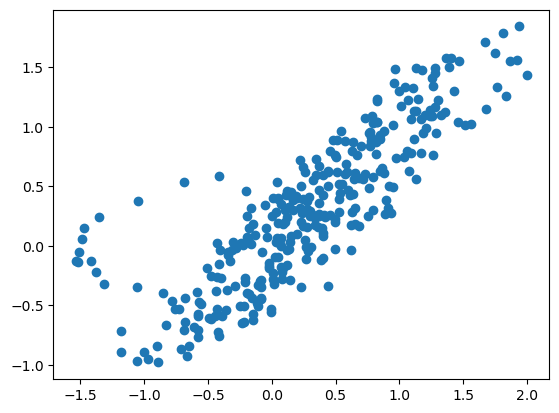

PyObject <matplotlib.collections.PathCollection object at 0x7f22dc8f0310>

In [137]:
scatter(decoder_outputs[1,:,20], ŷ[1,:,20])

In [136]:
nanmean3d((ŷ - decoder_outputs[:,:,4:end]).^2, keepdim=2)

320-element Vector{Float64}:
 1.1695721967619723
 1.2766793064514146
 1.3898763883828167
 1.462883272199958
 1.499032856267936
 1.4737425032195681
 1.4517213954984511
 1.4292901950490873
 1.4167334660139548
 1.413601923452304
 1.4113729832256239
 1.374375428995455
 1.3657532412304005
 ⋮
 1.6445290914241535
 1.5859938237947162
 1.533158559294544
 1.516267971702951
 1.5003160504502147
 1.490523845392924
 1.5040035340168934
 1.5123403528839794
 1.5628332062457988
 1.5695385117854297
 1.5539659963296613
 1.5417978359388118

## From disk

In [139]:
file_ix = 3  # file_ix ∈ [1,..,31]
c_U = this_expmtdata.Us[file_ix]
c_Y_tf = this_expmtdata.Ys[file_ix]
c_Urecon = mocaputil.invert(standardize_U, Matrix(c_U'));
c_Yrecon = mocaputil.invert(standardize_Y, Matrix(c_Y_tf'));

seq_ixs = 10:600  # which elements of the sequence to visualize
c_path_fk = geom.fk_path(c_Yrecon, seq_ixs, file_offsets[file_ix,:]);

In [140]:
size(c_Y_tf)

(67, 1328)

In [144]:
decoder_outputs = zeros(Float32, 1, 200, 64) * NaN
decoder_outputs[1,:,:] = transpose(c_Y_tf[4:end, 1:200]);

In [146]:
# Setup
USE_RANDOM_POSTERIOR = true
if !USE_RANDOM_POSTERIOR
    post = BSON.load(format("experiments/mtds-posterior/mocap_posterior_smp_{:d}.bson", style_ix))[:results]
    _zmu = [post[:Z][:, argmax(post[:weights][i,:])] for i in 1:_bsz]
else
    # some kind of approximation of true z without doing much work
    _zmu = mtorch.mt_net.Z_mu[Int(round(963*file_ix/31))].data.numpy()
end;

In [150]:
# Predict
ŷ = ones(1, 200, 64) * NaN
@pywith pytorch.no_grad() begin
    out = mtorch.forward(
        pytorch.tensor(reshape(c_U[:,1:200]', 1, :, 35)), 
        pytorch.tensor(_zmu).float(), 
        pytorch.ones(1,length(_zmu))*1f-5
    )[1].numpy()[1,:,:]
    ŷ[1,1:size(out,1), :] = out
end

In [154]:
ŷ[1,:,:]

200×64 Matrix{Float64}:
  0.0896823    1.38527    0.481604  …  -0.547377    -0.441469  -0.741591
  0.0449977    1.16729    0.689607     -0.831465    -0.578371  -1.53033
  0.0679289    0.922919   0.78615      -0.645579    -0.61758   -1.58304
  0.130968     1.09213    0.945186     -0.546946    -0.76753   -1.42851
  0.055144     1.17568    1.03791      -0.578748    -0.950561  -1.28678
  0.00953763   1.2229     1.10144   …  -0.561461    -1.1008    -1.04954
 -0.00101126   1.20249    1.18199      -0.48951     -1.16568   -0.747025
  0.0130337    1.1184     1.28287      -0.366063    -1.13444   -0.440104
  0.0297299    1.01023    1.38957      -0.21807     -1.03659   -0.168959
  0.00810977   0.926033   1.49604      -0.0984425   -0.944374   0.0700894
 -0.0248561    0.826656   1.5927    …  -0.0563712   -0.80729    0.285037
 -0.0364474    0.739374   1.67893      -0.0436279   -0.641986   0.464508
 -0.00552621   0.686139   1.7503        0.0405405   -0.477227   0.599065
  ⋮                            

In [153]:
decoder_outputs[1, :, :]

200×64 Matrix{Float64}:
 -0.0487285  -0.737807    0.316813    …   0.118871    -0.898207  -1.15777
 -0.0474629  -0.560248    1.54523         0.0442628   -0.886074  -1.46539
 -0.0460126  -0.352463    2.58352         0.00809169  -0.826761  -1.75923
 -0.0444812  -0.265161    1.53976         0.0129285   -0.784682  -1.95503
 -0.0429457  -0.205705    0.61657         0.0279358   -0.806297  -1.96008
 -0.0414666  -0.269267    0.156975    …   0.0229259   -0.865694  -1.81751
 -0.041746   -0.0784839   0.00810159     -0.00543952  -0.90598   -1.60765
 -0.0435954  -0.0638821  -0.319715       -0.0553952   -0.900904  -1.39877
 -0.0453086  -0.15318    -0.663726       -0.103341    -0.883408  -1.21351
 -0.0469486  -0.337367   -0.728069       -0.158646    -0.88251   -1.01564
 -0.0485685  -0.510189   -0.629668    …  -0.185388    -0.906394  -0.7661
 -0.0502112  -0.531286   -0.743063       -0.144238    -0.916253  -0.401913
 -0.0519087  -0.574651   -0.617639       -0.0153624   -0.809446   0.0629244
  ⋮         